## Импорт библиотек

In [33]:
import math
import pandas as pd
import numpy as np


from sklearn.preprocessing import LabelEncoder
from holidays import CountryHoliday

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

## Загрузка данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
from zipfile import ZipFile

with ZipFile("drive/MyDrive/Machine Learning projects/Playground Series/Season 3, Episode 19/playground-series-s3e19.zip") as myzip:
    train = myzip.open("train.csv")
    test = myzip.open("test.csv")
    submission = myzip.open("sample_submission.csv")
train = pd.read_csv(train)
test = pd.read_csv(test)
submission = pd.read_csv(submission)

In [ ]:
train.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [ ]:
test.head()

,id,date,country,store,product
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better


Задача: Предсказать годовой объем продаж различных курсов (***num_sold***)

## Разведочный анализ данных

In [35]:
train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)

In [ ]:
def info(df):
    print(f'размер датасета: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['data_type'])
    summary['missing_counts'] = df.isnull().sum()
    summary['%_missing'] = df.isnull().sum() / df.shape[0] * 100
    summary['number_of_unique'] = df.nunique()
    desc = df.describe(include = 'all').T
    try:
        summary['max'] = desc['max']
        summary['min'] = desc['min']
        summary['std'] = desc['std']
    except:
      print('Все признаки категориальные')

    summary['top'] = desc['top']
    summary['first_value'] = df.loc[0]

    return summary


In [ ]:
info(train)

размер датасета: (136950, 5)


,data_type,missing_counts,%_missing,number_of_unique,max,min,std,top,first_value
date,object,0,0.0,1826,NaN,NaN,NaN,2017-01-01,2017-01-01
country,object,0,0.0,5,NaN,NaN,NaN,Argentina,Argentina
store,object,0,0.0,3,NaN,NaN,NaN,Kaggle Learn,Kaggle Learn
product,object,0,0.0,5,NaN,NaN,NaN,Using LLMs to Improve Your Coding,Using LLMs to Improve Your Coding
num_sold,int64,0,0.0,1028,1380.0,2.0,183.691575,NaN,63


In [ ]:
info(test)

размер датасета: (27375, 4)
Все данные категориальные


,data_type,missing_counts,%_missing,number_of_unique,top,first_value
date,object,0,0.0,365,2022-01-01,2022-01-01
country,object,0,0.0,5,Argentina,Argentina
store,object,0,0.0,3,Kaggle Learn,Kaggle Learn
product,object,0,0.0,5,Using LLMs to Improve Your Coding,Using LLMs to Improve Your Coding


Кроме целевого признака все остальные категориальные

### Time feature engineering

Среди признаков есть время, переведем для начала в datetime, а далее достанем оттуда год, месяц, неделю, день в году, день в месяце, день недели

In [36]:
def go_to_date(df):

    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df['week'] = df['date'].dt.week
    df['year'] = df['date'].dt.year

    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day

    return df
train = go_to_date(train)
test = go_to_date(test)

In [ ]:
train.head()

,date,country,store,product,num_sold,month,week,year,dayofweek,dayofyear,dayofmonth
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63,1,52,2017,6,1,1
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66,1,52,2017,6,1,1
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9,1,52,2017,6,1,1
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59,1,52,2017,6,1,1
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49,1,52,2017,6,1,1


### Feature Distribution of Categorical Features

In [37]:
cat_features = ['country', 'store', 'product']
num_features = [x for x in train.columns if x not in  ['num_sold', 'date'] and x not in cat_features]

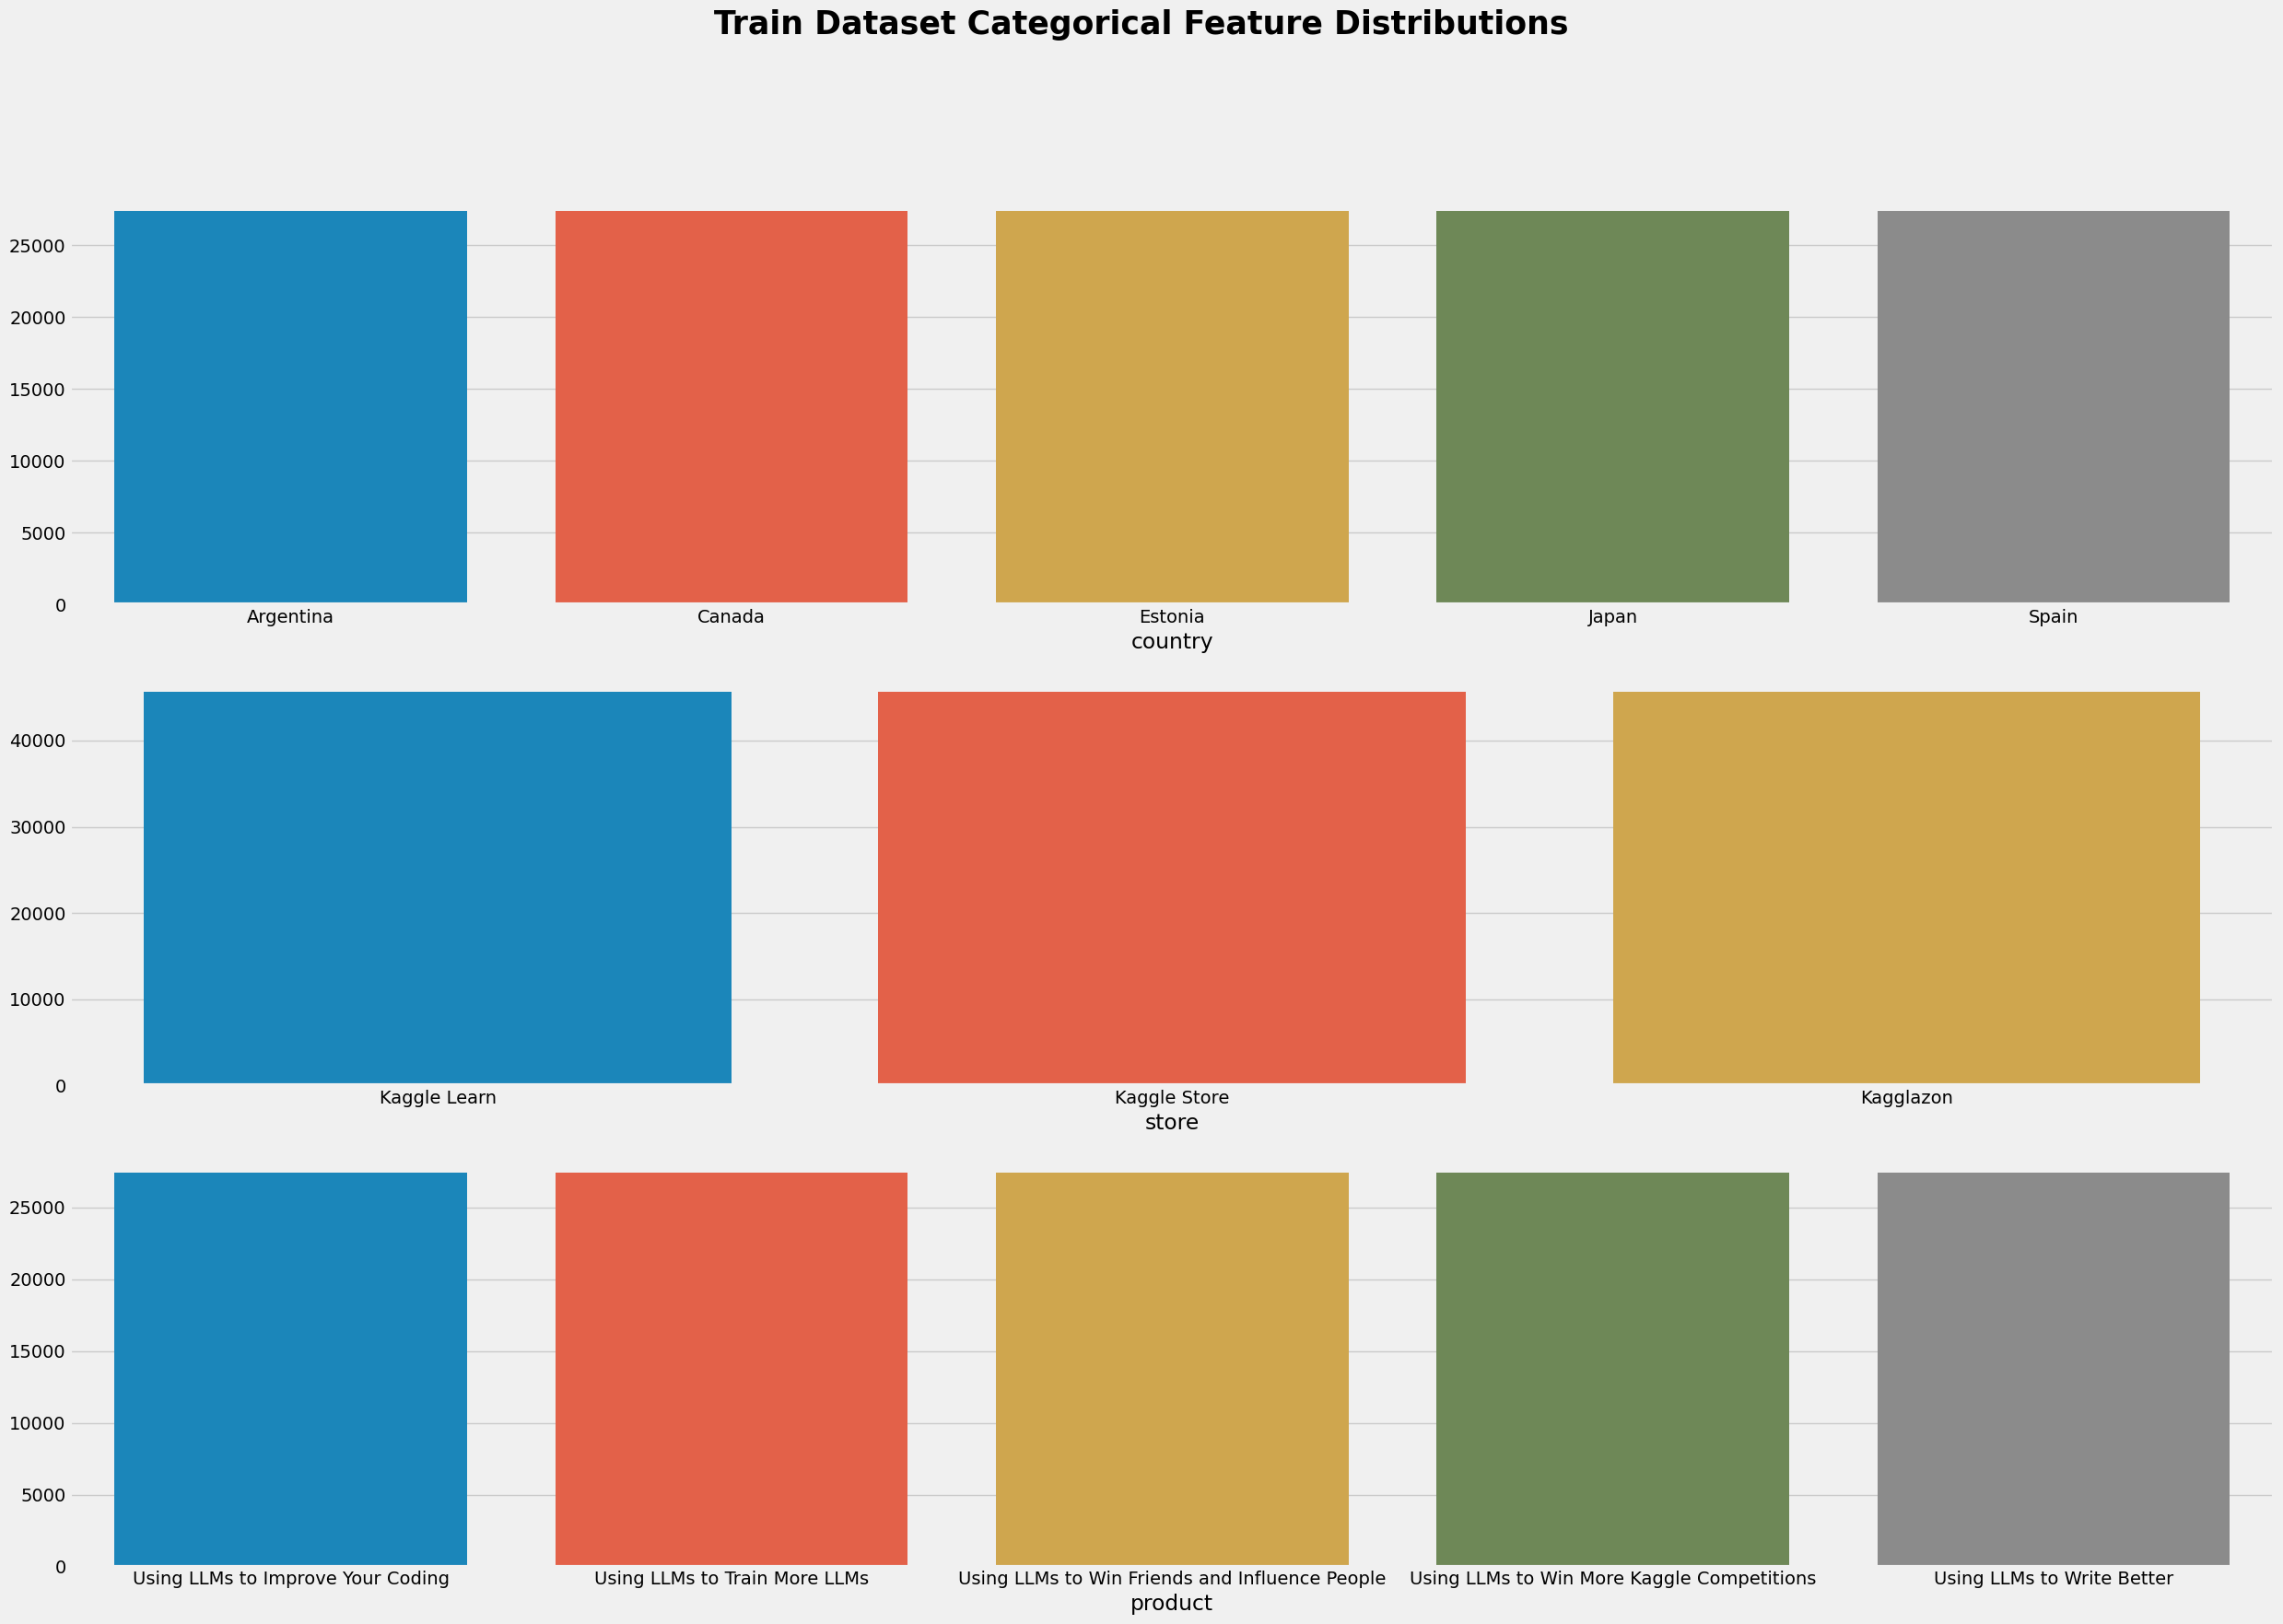

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(25,18))
ax = ax.flatten()

for i, col in enumerate(cat_features):
    sns.countplot(data=train, x=col, ax=ax[i])
    ax[i].set_ylabel('')

fig.suptitle(f'Train Dataset Categorical Feature Distributions\n\n\n\n', ha='center',  fontweight='bold', fontsize=25)
plt.tight_layout() # уменьшает зазор между названием графика и самим графиком

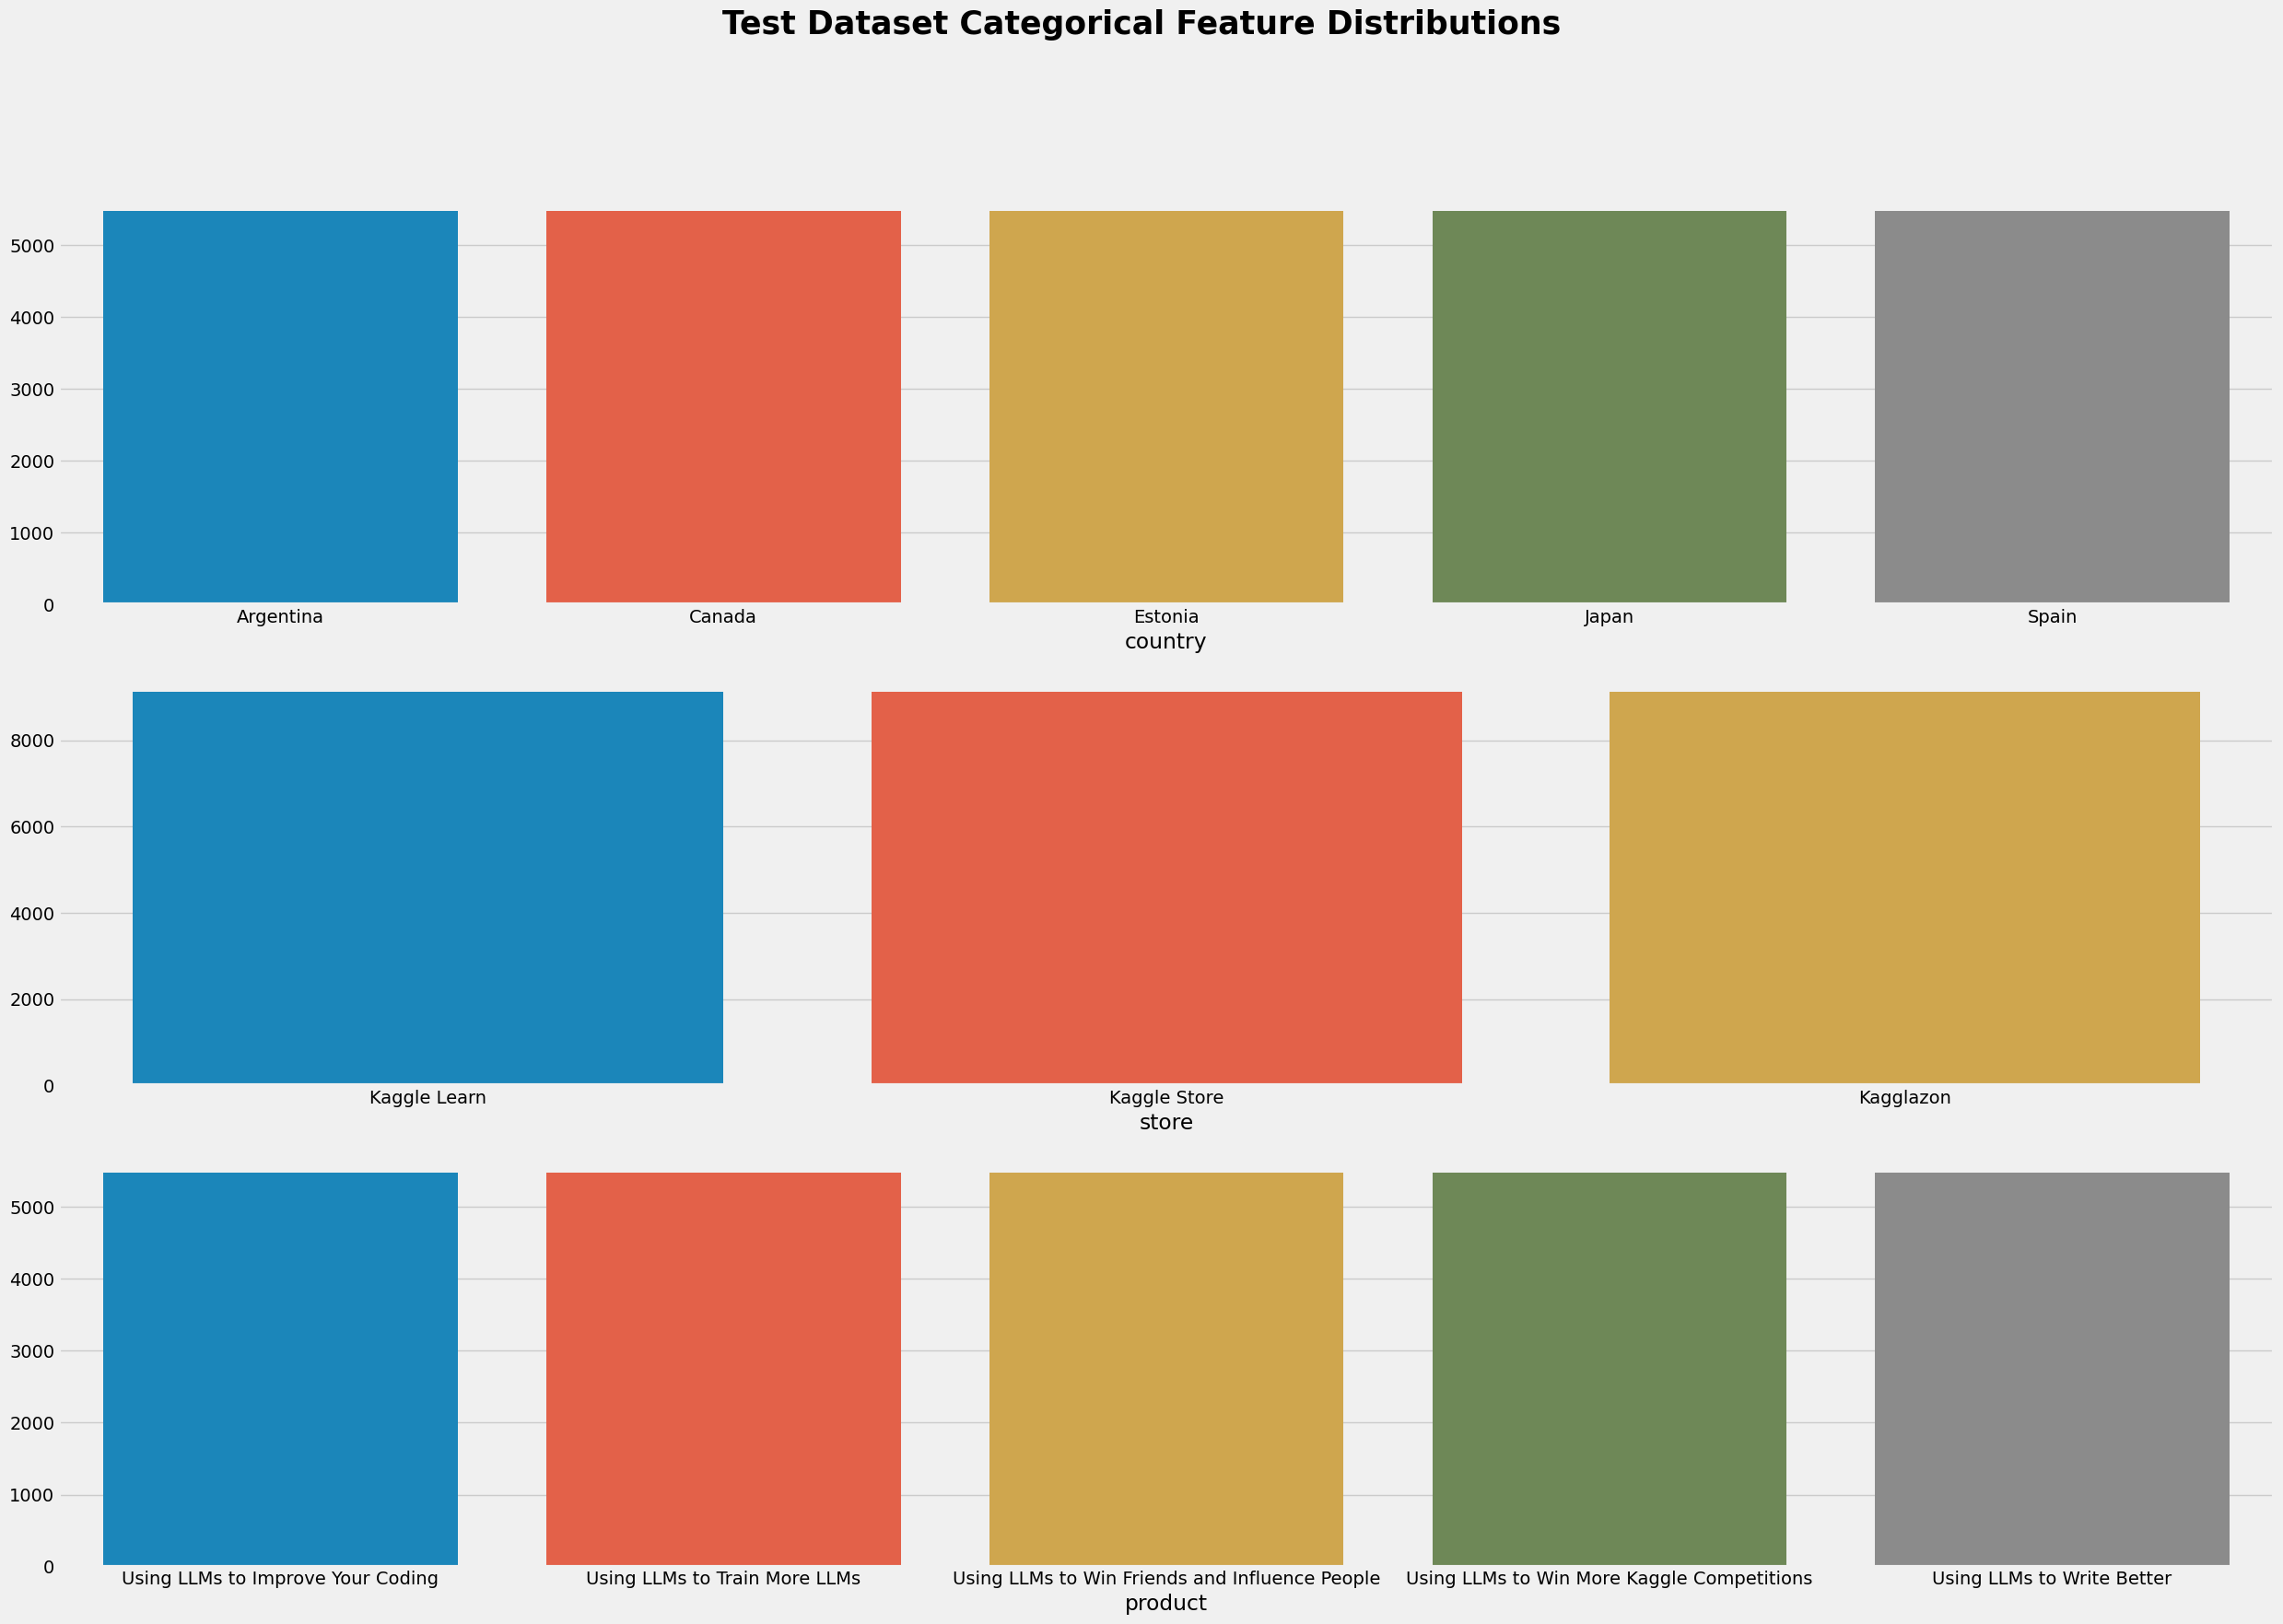

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(25,18))
ax = ax.flatten()

for i, col in enumerate(cat_features):
    sns.countplot(data=test, x=col, ax=ax[i])
    ax[i].set_ylabel('')

fig.suptitle(f'Test Dataset Categorical Feature Distributions\n\n\n\n', ha='center',  fontweight='bold', fontsize=25)
plt.tight_layout() # уменьшает зазор между названием графика и самим графиком

Все категориальные признаки распределены равномерно

### Анализ временных рядов

#### Продажи за все время

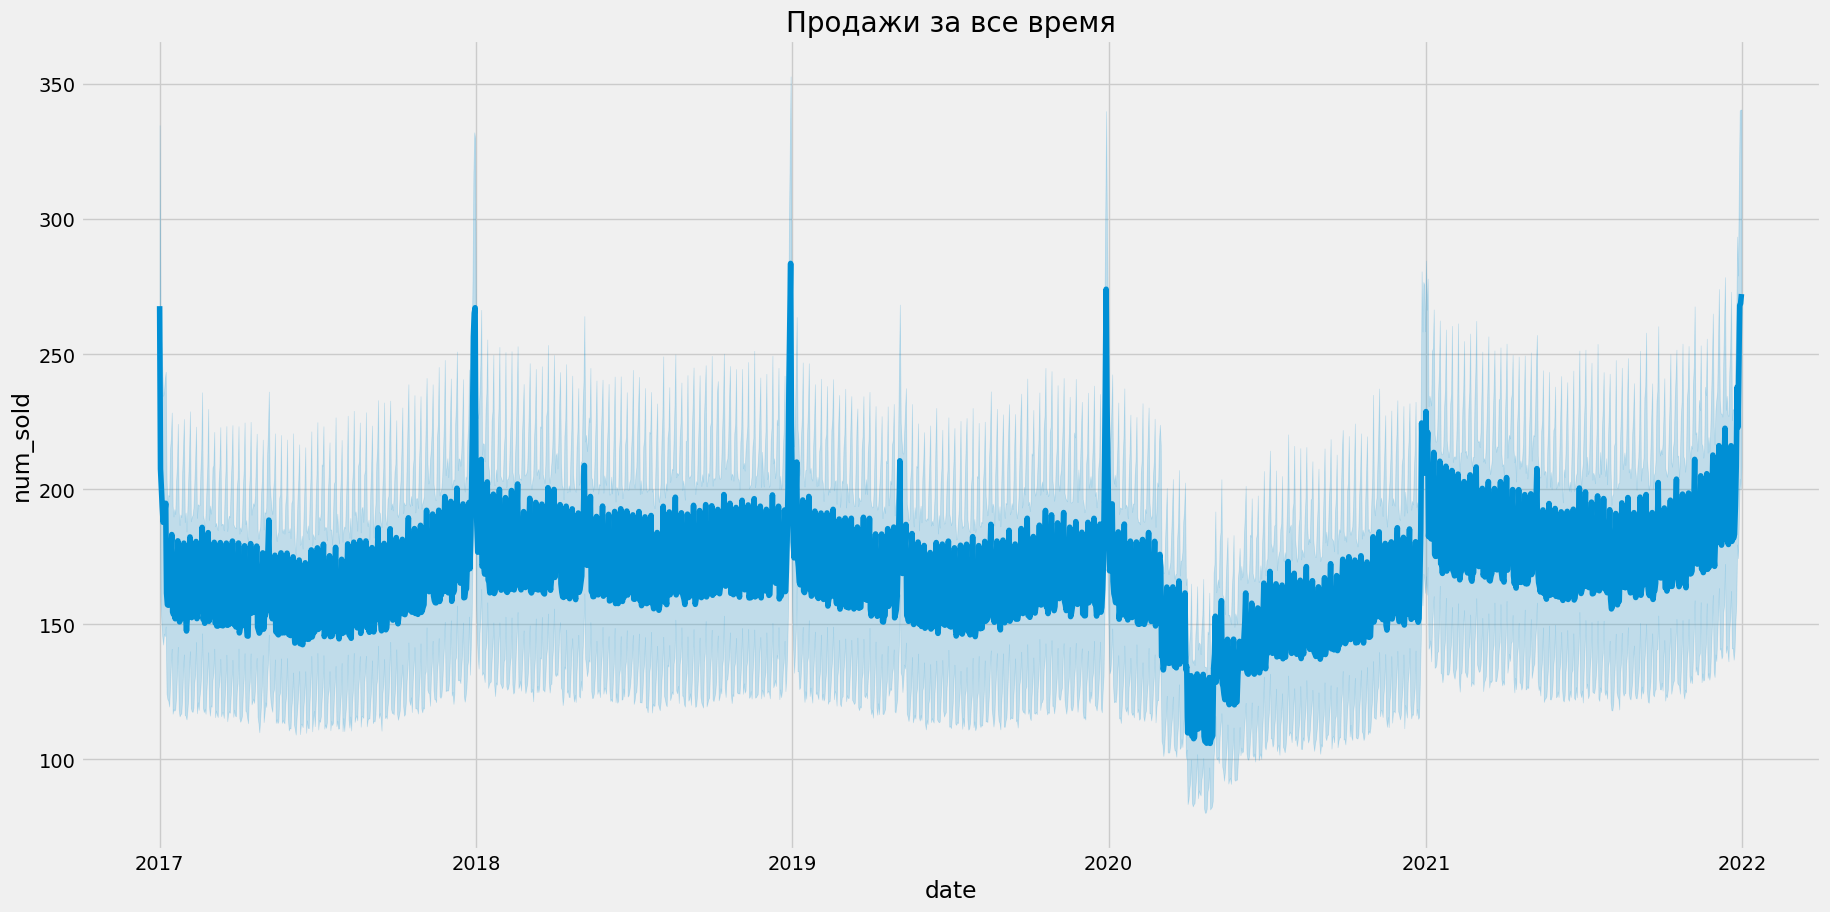

In [ ]:
plt.figure(figsize=(20, 10))

sns.lineplot(data=train, x='date', y='num_sold')
plt.title('Продажи за все время', fontsize=20)
plt.show()

Сезонность наблюдается. Ближе к новому году значительно вырастают объемы продаж курсов. Также заметим аномальный спад в начале *2020* года (короновирус)

#### Помесячные продажи за весь период

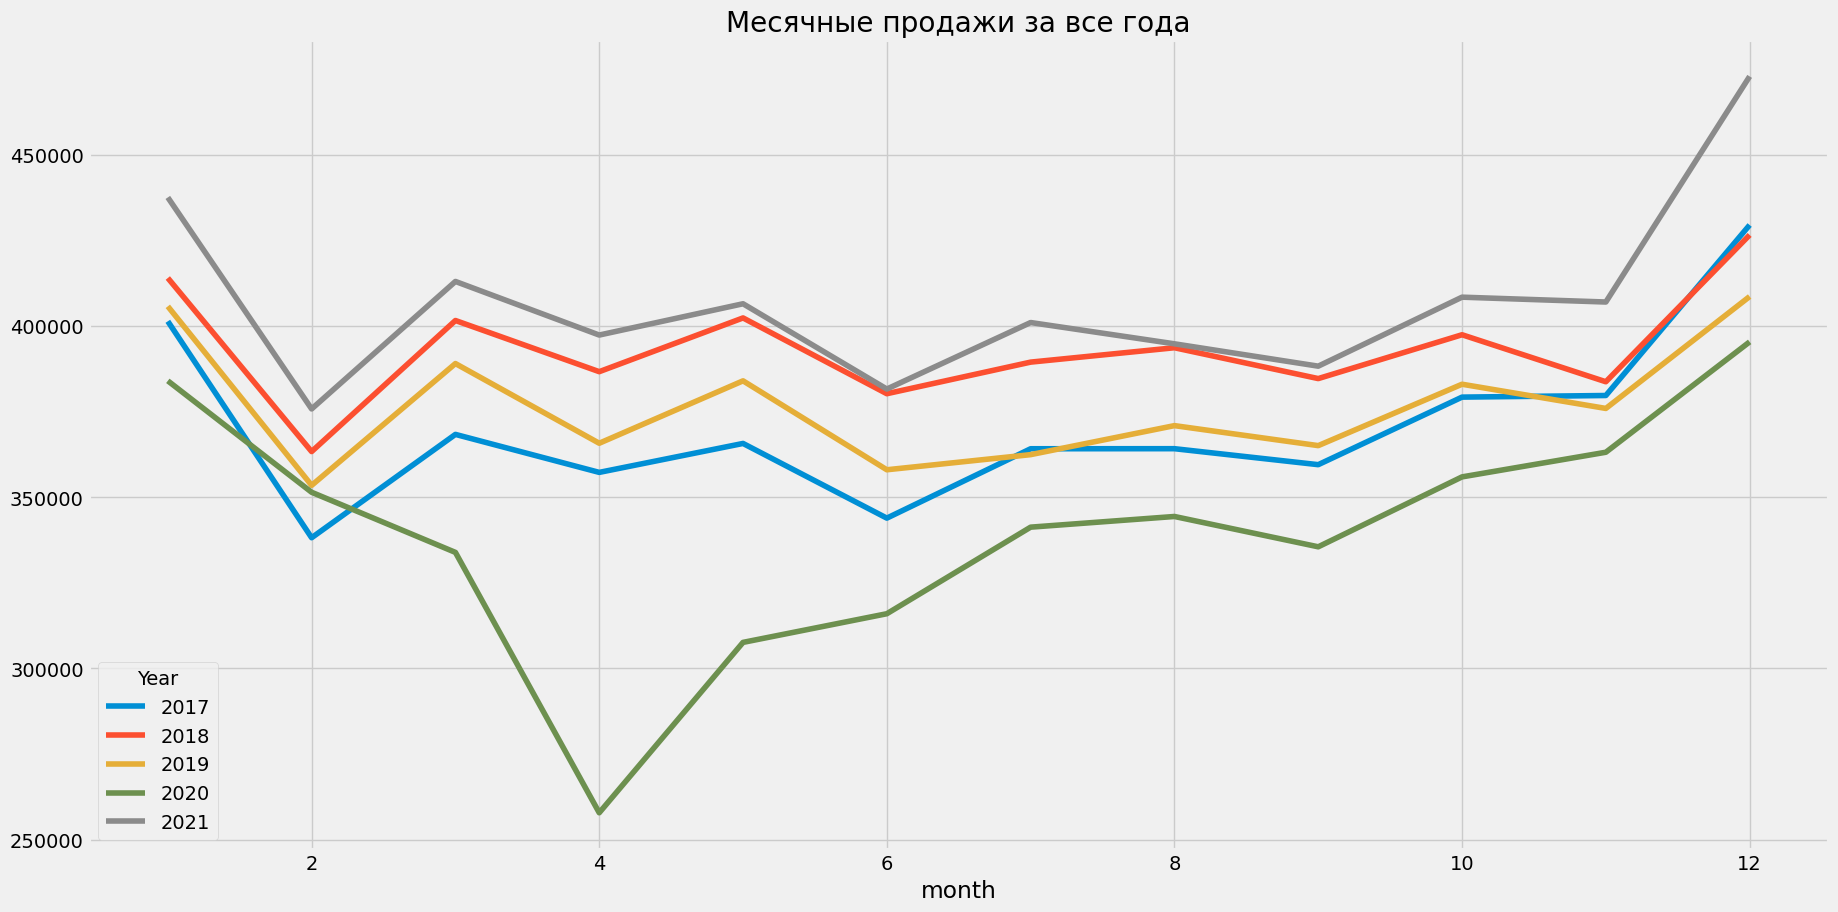

In [ ]:
monthly_sales_year = train.groupby(['year', 'month'])['num_sold'].sum().reset_index()
plt.figure(figsize=(20, 10))

for year in sorted(list(train.year.unique())):
    sns.lineplot(data=monthly_sales_year,
                 x=monthly_sales_year[monthly_sales_year['year']==year]['month'],
                 y=monthly_sales_year[monthly_sales_year['year']==year]['num_sold'],
                 label=year)

plt.ylabel('')
plt.legend(title='Year')
plt.title('Месячные продажи за все года')
plt.show()

Более детальный график, есть спад продаж в марте-апреле 2020 года, также замечается характерный рост продаж ближе к концу каждого года

In [ ]:
train.head()

,date,country,store,product,num_sold,month,week,year,dayofweek,dayofyear,dayofmonth
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63,1,52,2017,6,1,1
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66,1,52,2017,6,1,1
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9,1,52,2017,6,1,1
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59,1,52,2017,6,1,1
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49,1,52,2017,6,1,1


#### Недельные продажи за весь период

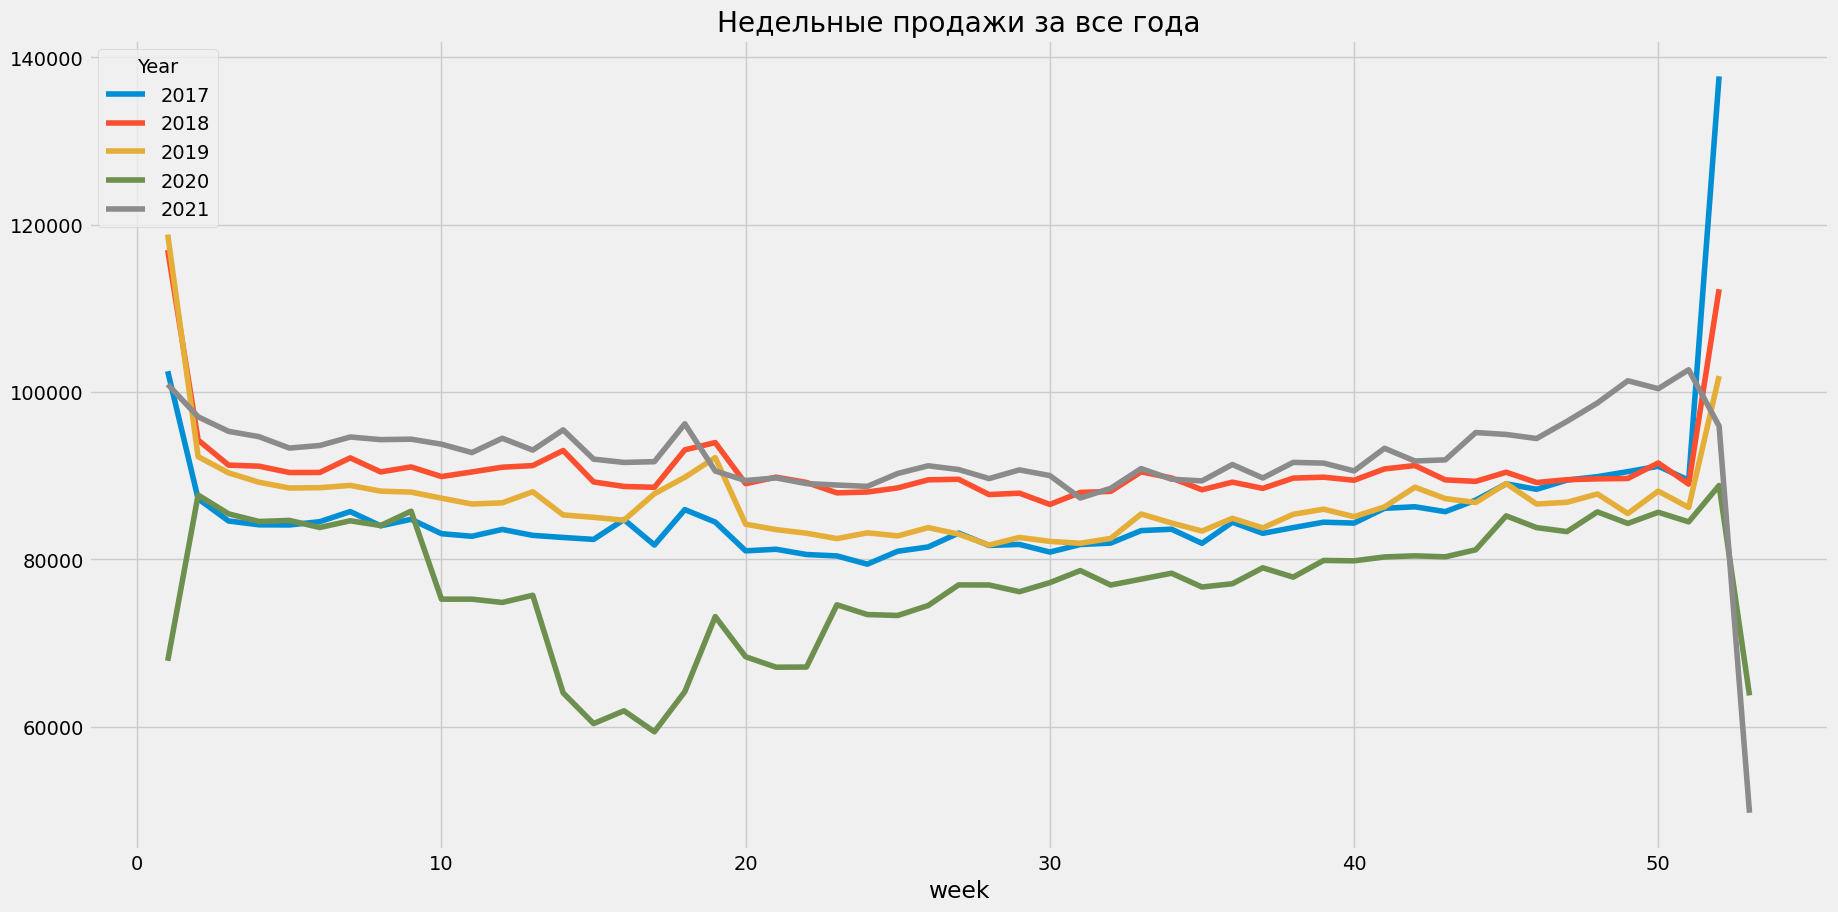

In [ ]:
weekly_sales_year = train.groupby(['year', 'week'])['num_sold'].sum().reset_index()
plt.figure(figsize=(20, 10))

for year in sorted(list(train.year.unique())):
    sns.lineplot(data=weekly_sales_year,
                 x=weekly_sales_year[weekly_sales_year['year']==year]['week'],
                 y=weekly_sales_year[weekly_sales_year['year']==year]['num_sold'],
                 label=year)

plt.ylabel('')
plt.legend(title='Year')
plt.title('Недельные продажи за все года')
plt.show()

Концы не сходятся и понятно почему (последняя неделя в году может состоять не из 7 дней). Вызывает интерес всплекс продаж в 17-20 недели каждого года, включая 2020 год. Нельзя сказать, что статистика продаж несет сезонный недельный характер

Можно предположить, что сезонность присутствует, характерный спад продаж в феврале, апреле, июне. В марте, мае и в последние месяцы года наблюдается повышенный спрос на курсы

In [ ]:
# monthly_sales_year_country = train.groupby(['year', 'month', 'country'])['num_sold'].sum().reset_index()

#### Продажи по странам

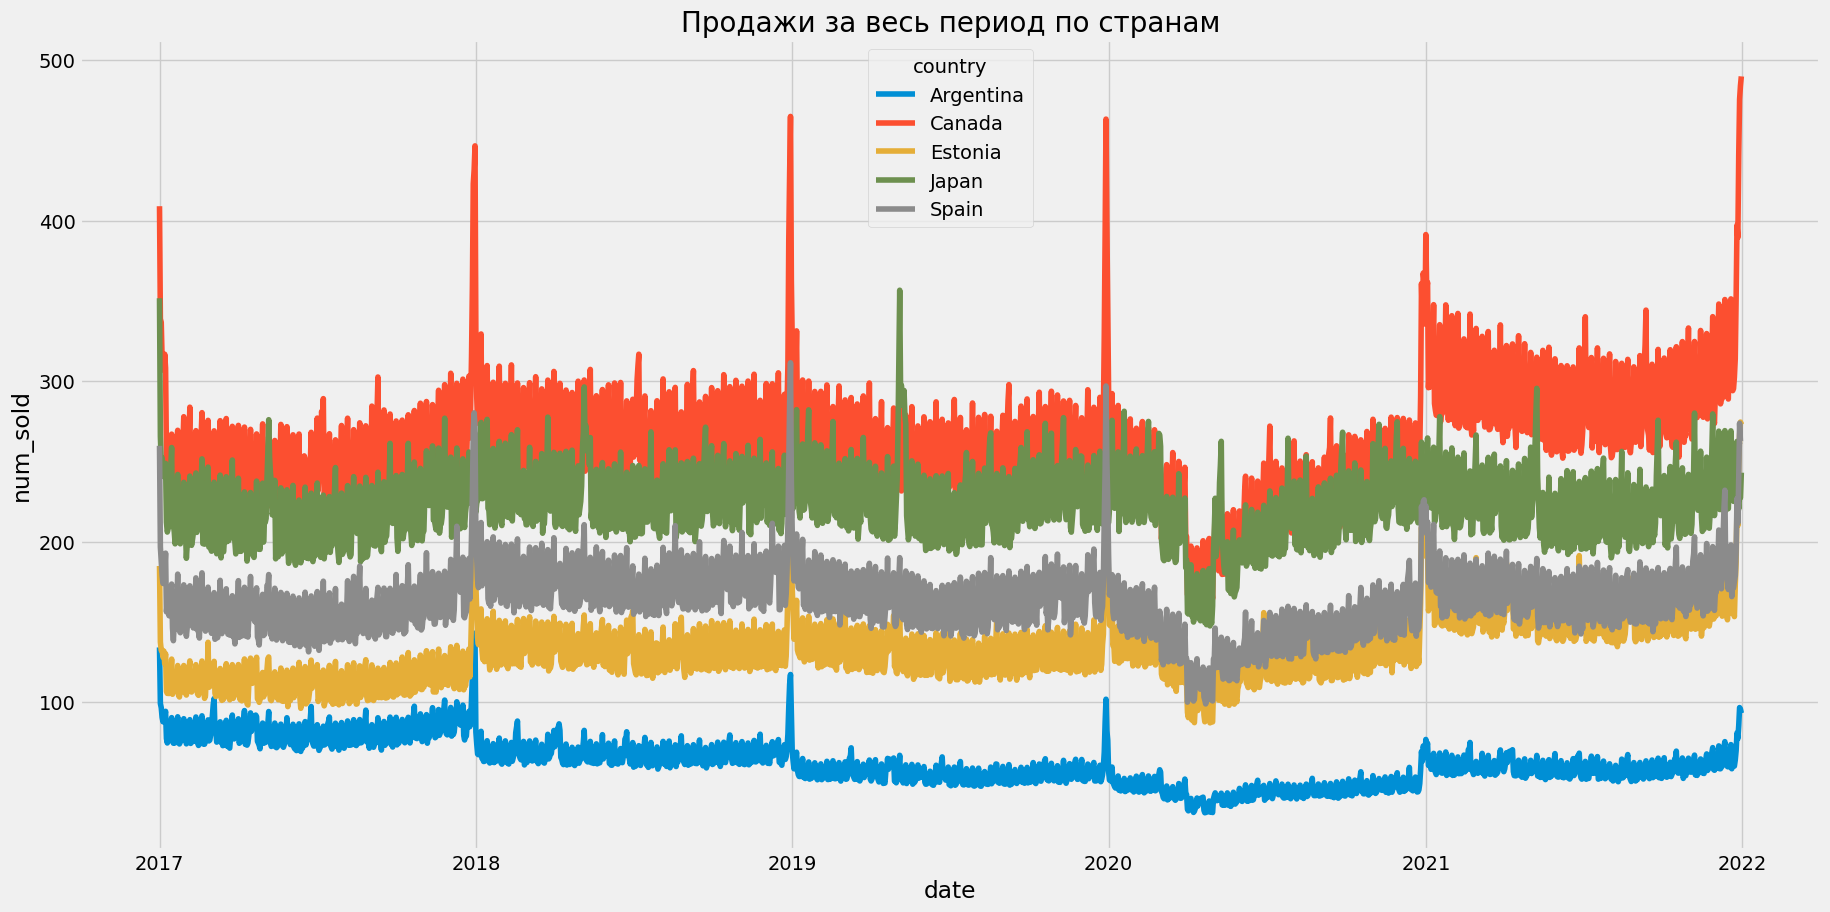

In [ ]:
plt.figure(figsize=(20, 10))

sns.lineplot(data=train, x='date', y='num_sold', hue='country', errorbar = None)
plt.title('Продажи за весь период по странам', fontsize=20)
plt.show()

В Аргентине и в Эстонии меньше всего покупают курсы. В Канаде и в Японии к курсам повышенный спрос

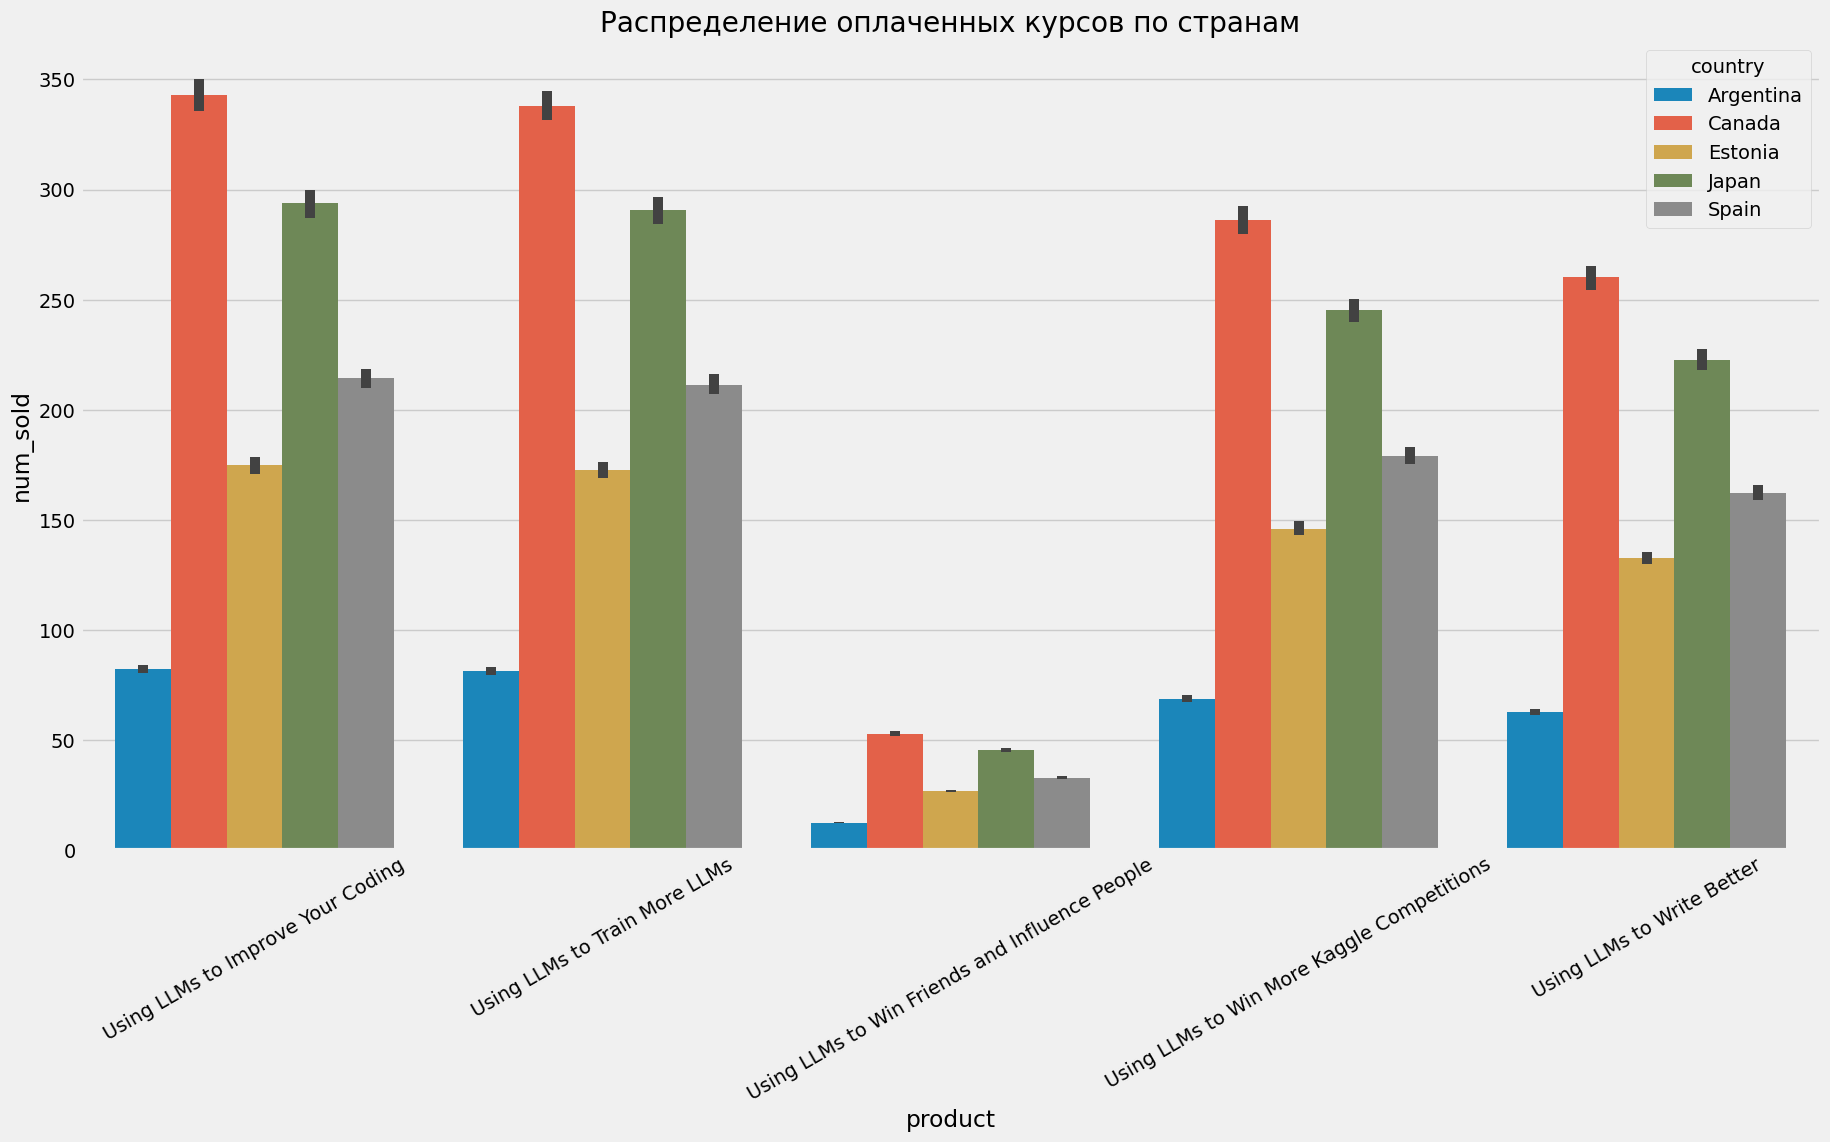

In [ ]:
plt.figure(figsize=(20, 10))

sns.barplot(data=train, x='product', y='num_sold', hue='country')
plt.title('Распределение оплаченных курсов по странам')
plt.xticks(rotation=30)
plt.show()

Распределение проданных курсов по разным странам одинаково. Каждый курс вызывал большой спрос в Канаде, а также заурядно продавался в Аргентине

#### Продажи каждого курса за весь период

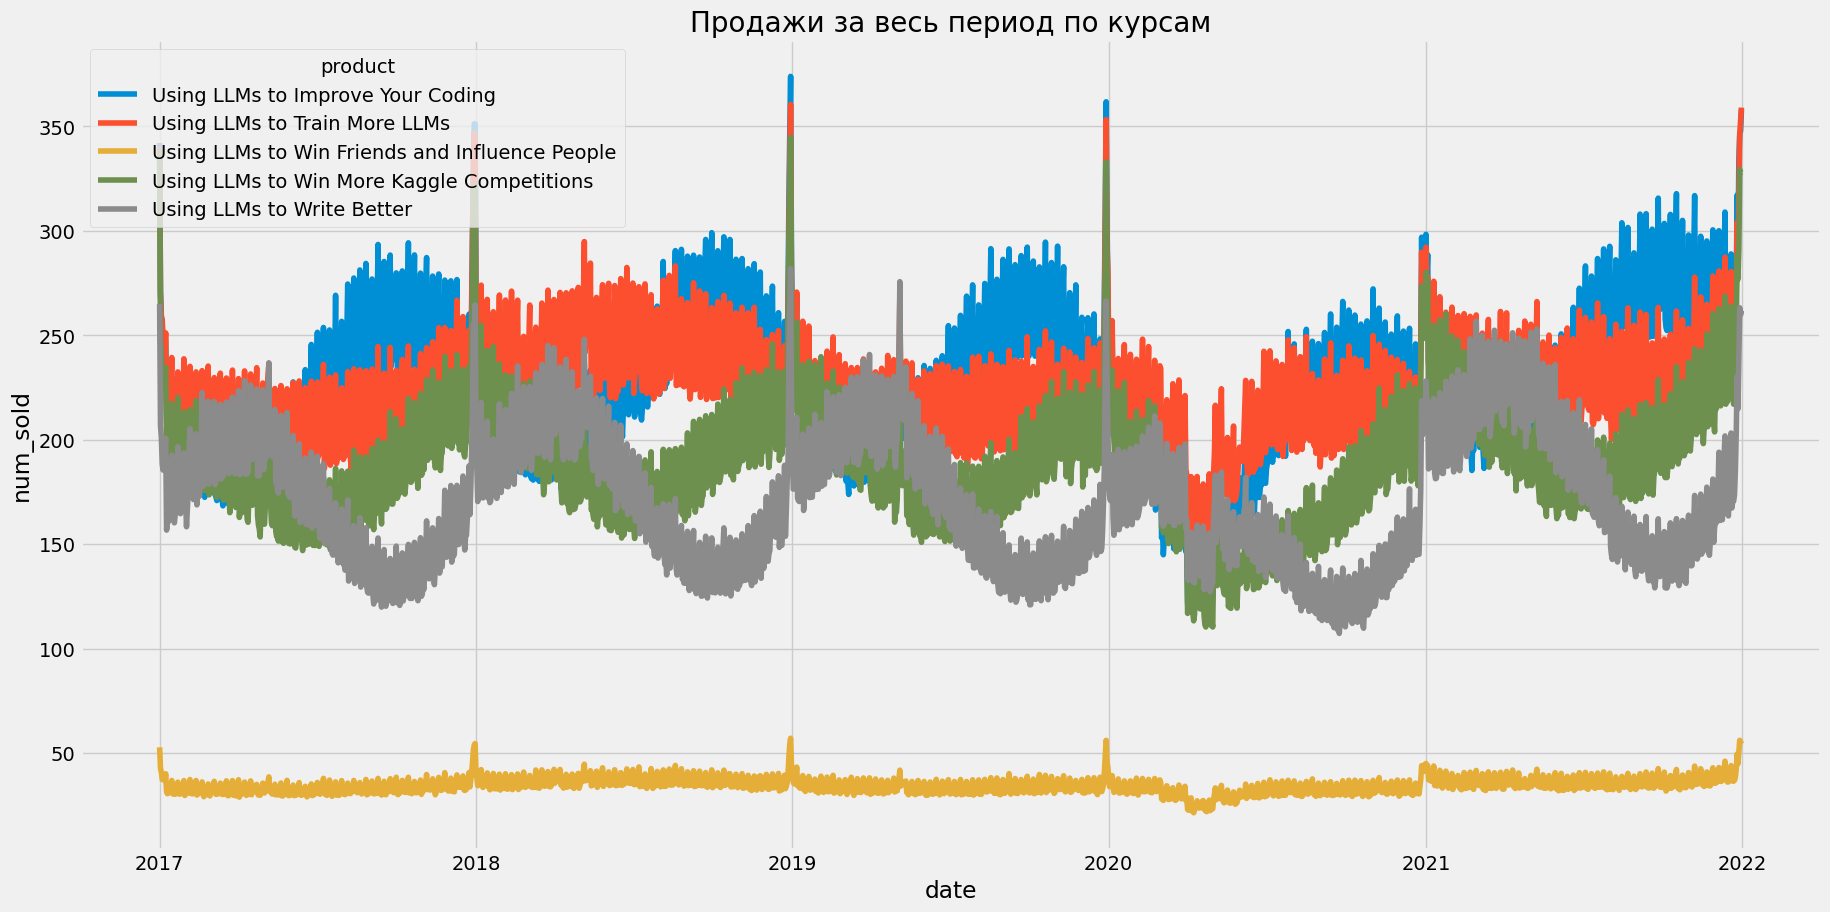

In [ ]:
plt.figure(figsize=(20, 10))

sns.lineplot(data=train, x='date', y='num_sold', hue='product', errorbar = None)
plt.title('Продажи за весь период по курсам', fontsize=20)
plt.show()

Курс ***'Using LLMs to Win Friends and Influence People'*** не пользуется популярностью в магазинах. Остальные 4 курса имеют почти одинаковый спрос

#### Продажи по магазинам

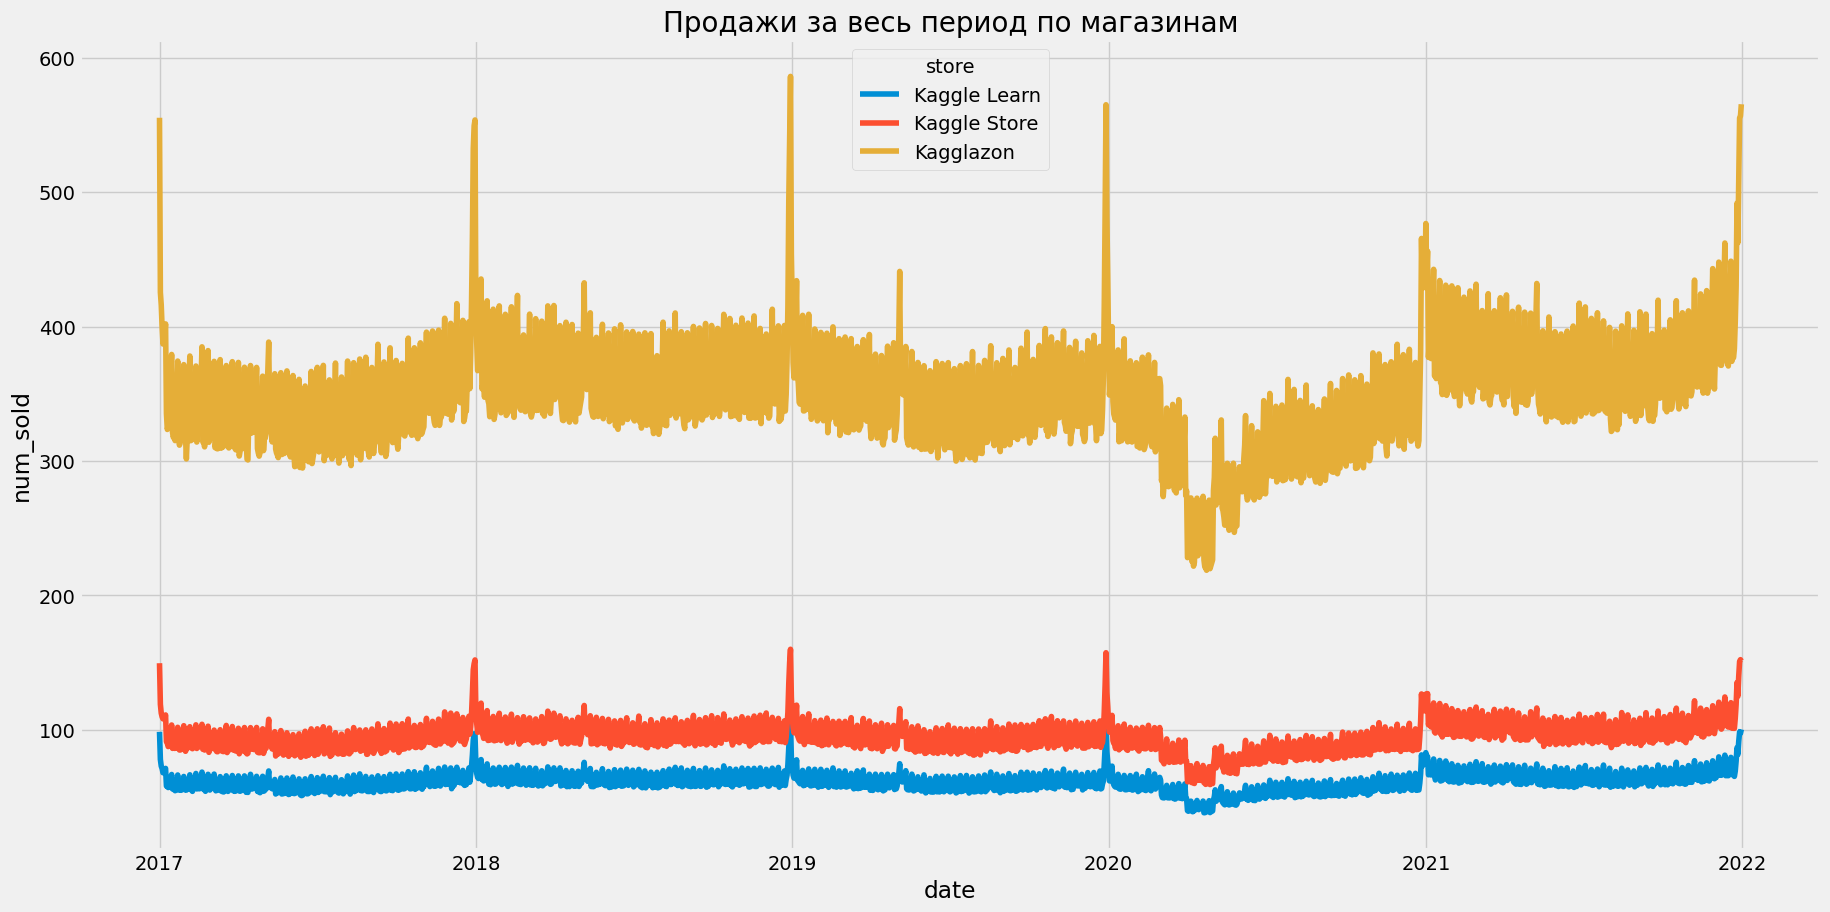

In [ ]:
plt.figure(figsize=(20, 10))

sns.lineplot(data=train, x='date', y='num_sold', hue='store', errorbar = None)
plt.title('Продажи за весь период по магазинам', fontsize=20)
plt.show()

***Kagglazon*** лидерует по продажам курсов. Этот магазин более предпочтителен относительно двух других

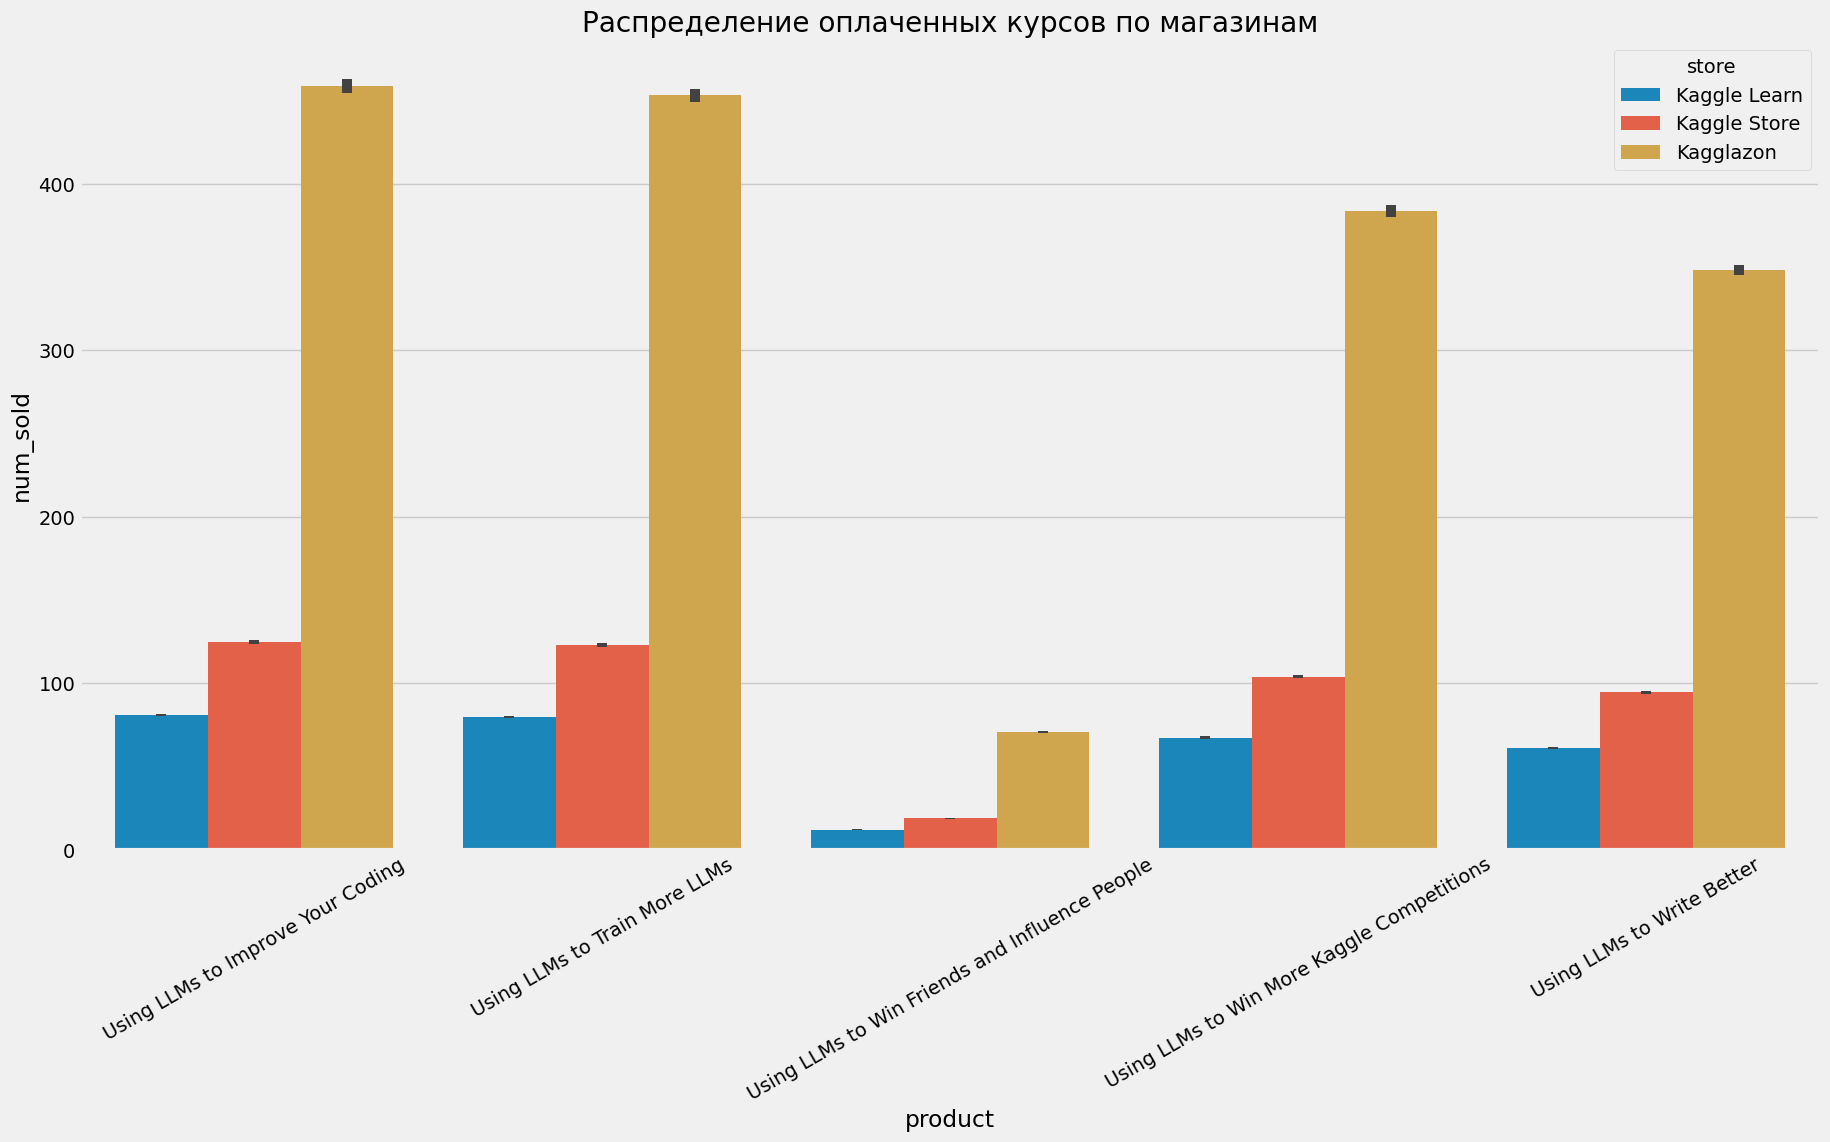

In [ ]:
plt.figure(figsize=(20, 10))

sns.barplot(data=train, x='product', y='num_sold', hue='store')
plt.title('Распределение оплаченных курсов по магазинам')
plt.xticks(rotation=30)
plt.show()

Тут тоже без интересных наблюдений

#### Выбросы

Удалим данные в период с 01.03.2020 по 01.07.2020. Это время первой волны пандемии, поэтому продажи здесь чрезвычайно низкие и их можно исключить как выбросы  

In [38]:
train = train[(train['date'] < '2020-03-01') | (train['date'] > '2020-07-01')]

In [ ]:
train.shape

(127725, 5)

### Feature Engineering

Добавим информацию о праздниках, как и местных так и общих

In [62]:
def getHoliday(df):
    country_list = [c for c in list(df.country.unique())]
    years = np.arange(df['year'].min(), df['year'].max() + 1)
    holidays = pd.DataFrame(columns=['date', 'holiday', 'country'])

    for country in tqdm(country_list):
        for h in CountryHoliday(country=country, years=years).items():
            row = len(holidays)
            if h[1] == 'National Census Day 2022':
                continue
            holidays.loc[row, 'date'] = h[0]
            holidays.loc[row, 'holiday'] = h[1]
            holidays.loc[row, 'country'] = country
    # Добавим общие рождественские каникулы
    common_holidays = pd.DataFrame({
    'date': pd.to_datetime(['2017-12-24', '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29', '2017-12-30', '2017-12-31',
                            '2018-12-24', '2018-12-25', '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29', '2018-12-30', '2018-12-31',
                            '2019-12-24', '2019-12-25', '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29', '2019-12-30', '2019-12-31',
                            '2020-12-24', '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29', '2020-12-30', '2020-12-31',
                            '2021-12-24', '2021-12-25', '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30', '2021-12-31',
                            '2022-12-24', '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30', '2022-12-31']),
    'holiday': 'Christmas'
    })

    country_common_holidays = pd.DataFrame()
    for country in country_list:
        copy_common_holidays = common_holidays.copy()
        copy_common_holidays['country'] = country
        country_common_holidays = pd.concat([country_common_holidays, copy_common_holidays], ignore_index=True)

    holidays = pd.concat([holidays, country_common_holidays], ignore_index=True)
    holidays['date'] = pd.to_datetime(holidays['date'])
    holidays['isHoliday'] = 1

    df = df.merge(holidays, how='left', on=['date', 'country'])
    df['holiday'] = df['holiday'].fillna('Not Holiday')
    df['isHoliday'] = df['isHoliday'].fillna(0)

    df = df.drop_duplicates(subset=['date', 'country', 'product', 'store'],
                            keep='first')

    return df

train_h = getHoliday(train)
test_h = getHoliday(test)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
train_h.head()

,date,country,store,product,num_sold,month,week,year,dayofweek,dayofyear,dayofmonth,holiday,isHoliday
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63,1,52,2017,6,1,1,New Year's Day,1.0
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66,1,52,2017,6,1,1,New Year's Day,1.0
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9,1,52,2017,6,1,1,New Year's Day,1.0
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59,1,52,2017,6,1,1,New Year's Day,1.0
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49,1,52,2017,6,1,1,New Year's Day,1.0


Выполним преобразование Фурье

In [63]:
def seasonality_features(df):
    df['month_sin'] = np.sin(2*np.pi*df.month/12)
    df['month_cos'] = np.cos(2*np.pi*df.month/12)

    df['day_cos'] = np.sin(2*np.pi*df.dayofmonth/31)
    df['day_cos'] = np.cos(2*np.pi*df.dayofmonth/31)


    return df

train_h = seasonality_features(train_h)
test_h = seasonality_features(test_h)

In [64]:
train_h.head()

,date,country,store,product,num_sold,month,week,year,dayofweek,dayofyear,dayofmonth,holiday,isHoliday,month_sin,month_cos,day_cos
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63,1,52,2017,6,1,1,New Year's Day,1.0,0.5,0.866025,0.97953
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66,1,52,2017,6,1,1,New Year's Day,1.0,0.5,0.866025,0.97953
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9,1,52,2017,6,1,1,New Year's Day,1.0,0.5,0.866025,0.97953
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59,1,52,2017,6,1,1,New Year's Day,1.0,0.5,0.866025,0.97953
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49,1,52,2017,6,1,1,New Year's Day,1.0,0.5,0.866025,0.97953


### Target distribution

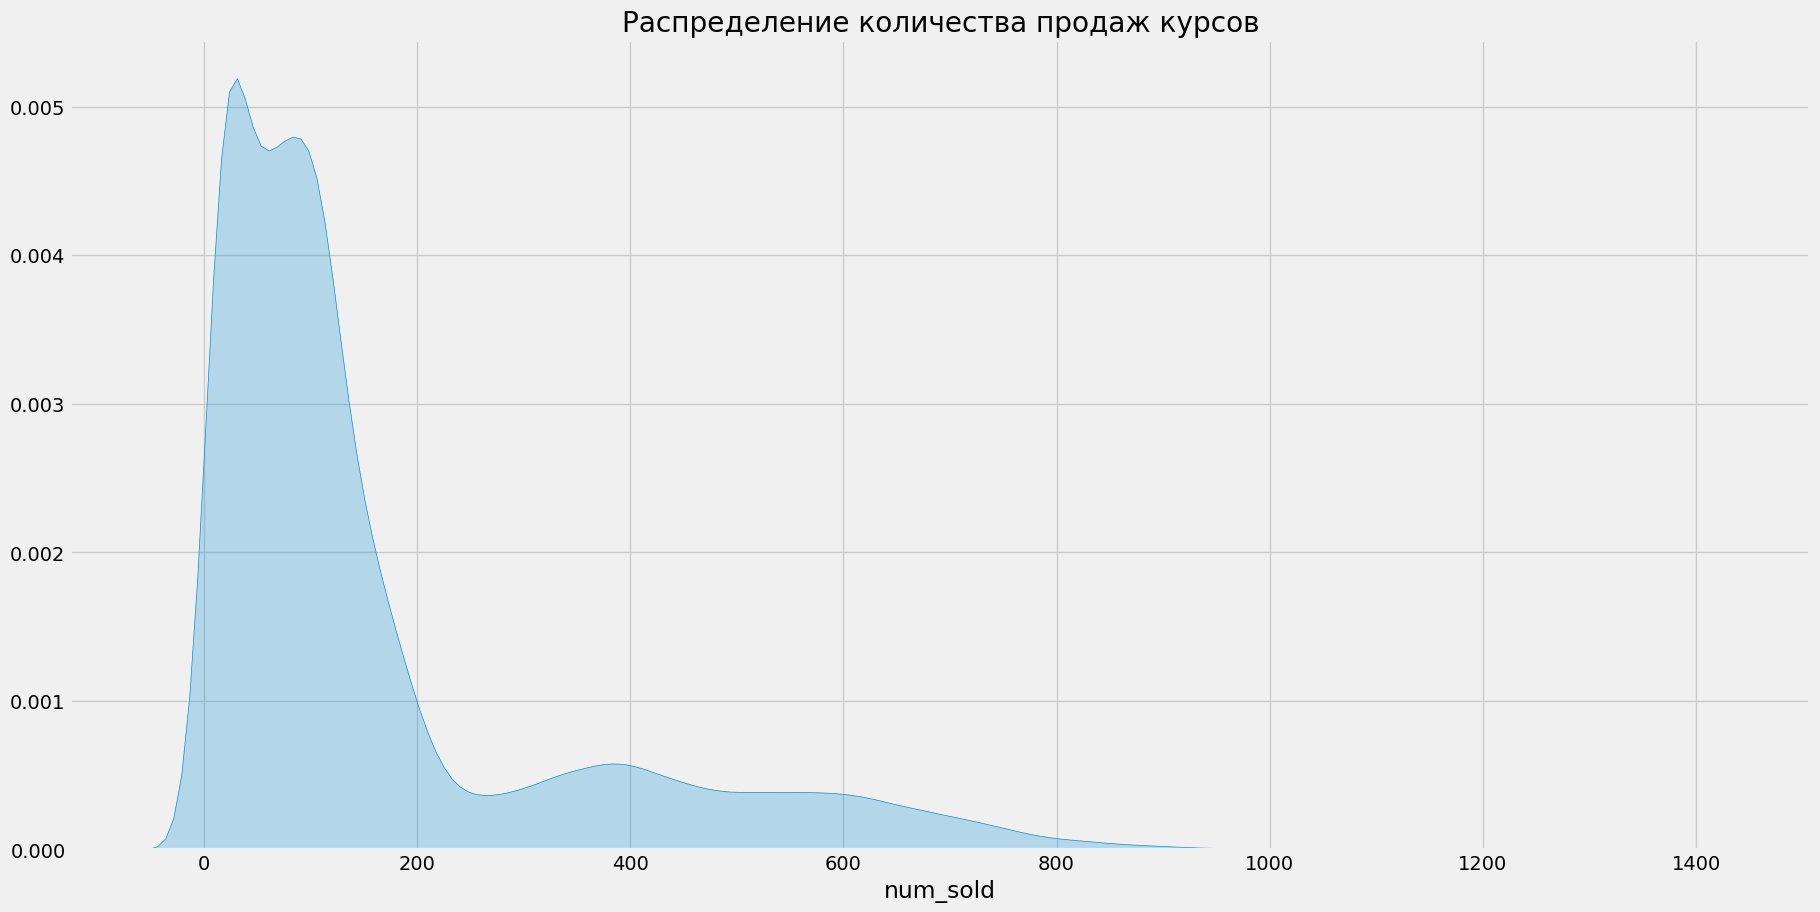

In [65]:
plt.figure(figsize=(20,10))
sns.kdeplot(data=train_h, x='num_sold', fill=True, color=color_pal[0])
plt.ylabel('')
plt.title('Распределение количества продаж курсов')
plt.show()

Смещенное влево распределение целевого признака, схожа с логарифмическим распределением

Попробуем нормализовать его с помощью логарифмирование переменной для успешного обучения моделей

In [66]:
train_h['num_sold'] = np.log1p(train_h['num_sold'])

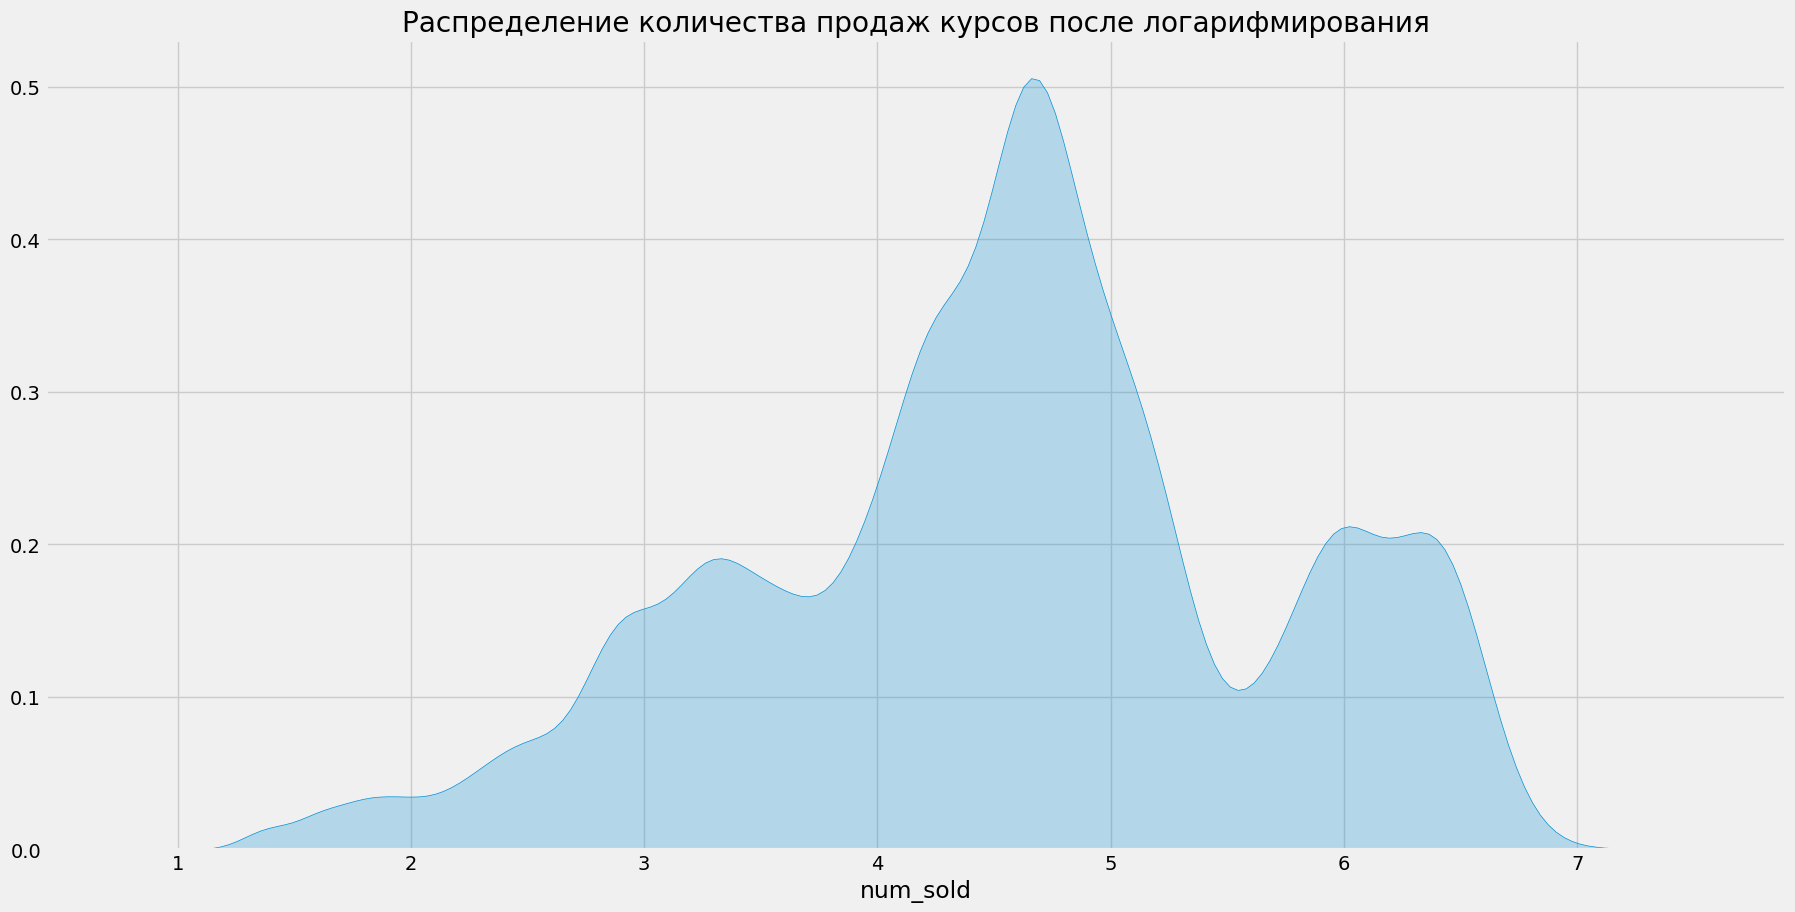

In [67]:
plt.figure(figsize=(20,10))
sns.kdeplot(data=train_h, x='num_sold', fill=True, color=color_pal[0])
plt.ylabel('')
plt.title('Распределение количества продаж курсов после логарифмирования')
plt.show()

## Обучение

Напишем метрику, которая будет оценивать качество предсказаний модели

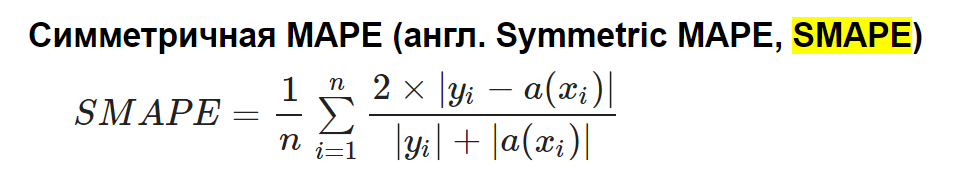

In [117]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [69]:
cat_features.append('holiday')

При первой попытке закодировать категориальные данные, вылезла ошибка, что
в тесте есть данные, которые отсутствуют в обучении. А именно ***National Census Day 2022*** (Национальный день переписи населения **18/05/2022**) в Аргентине, который в последний раз был в 2010 году. Таких записей всего 15, удалять тестовые данные нельзя, поэтому мы просто проигнорировали этот выходной, посчитав его за обычный день

In [75]:
test_h[(test_h['date'] == '2022-05-18') & (test_h['country'] == 'Argentina')]['holiday']

10275    Not Holiday
10276    Not Holiday
10277    Not Holiday
10278    Not Holiday
10279    Not Holiday
10280    Not Holiday
10281    Not Holiday
10282    Not Holiday
10283    Not Holiday
10284    Not Holiday
10285    Not Holiday
10286    Not Holiday
10287    Not Holiday
10288    Not Holiday
10289    Not Holiday
Name: holiday, dtype: object

In [76]:
le = LabelEncoder()

for col in cat_features:
    train_h[col] = le.fit_transform(train_h[col])
    test_h[col] = le.transform(test_h[col])

Возьмем данные до *01/01/2021* в тренировочный набор, а оставшиеся в валидационный набор

In [77]:
X_train = train_h[train_h['date'] < '2021-01-01'].drop(columns=['date', 'num_sold'])
y_train = train_h[train_h['date'] < '2021-01-01']['num_sold'].copy()

X_valid = train_h[train_h['date'] >= '2021-01-01'].drop(columns=['date', 'num_sold'])
y_valid = train_h[train_h['date'] >= '2021-01-01']['num_sold'].copy()

In [78]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100350 entries, 0 to 100829
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   country     100350 non-null  int64  
 1   store       100350 non-null  int64  
 2   product     100350 non-null  int64  
 3   month       100350 non-null  int64  
 4   week        100350 non-null  int64  
 5   year        100350 non-null  int64  
 6   dayofweek   100350 non-null  int64  
 7   dayofyear   100350 non-null  int64  
 8   dayofmonth  100350 non-null  int64  
 9   holiday     100350 non-null  int64  
 10  isHoliday   100350 non-null  float64
 11  month_sin   100350 non-null  float64
 12  month_cos   100350 non-null  float64
 13  day_cos     100350 non-null  float64
dtypes: float64(4), int64(10)
memory usage: 11.5 MB


#### KFold cross validation

In [81]:
# pip install catboost

In [82]:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [104]:
RANDOM_STATE = 42
lgb_reg = LGBMRegressor(random_state=RANDOM_STATE, objective='mae')
xgb_reg = XGBRegressor(random_state=RANDOM_STATE, objective='reg:absoluteerror')
cb_reg = CatBoostRegressor(silent=True, random_state=RANDOM_STATE, objective='MAE')

In [149]:
def training_kf(model, X_train, y_train,  X_valid, y_valid):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    score = smape(np.exp(y_pred), np.exp(y_valid))
    # print(f'SMAPE: {score}')

    return np.mean(score)

In [120]:
cb_reg_kf_score = training_kf(cb_reg, X_train, y_train, X_valid, y_valid)

MODEL: CatBoostRegressor


In [122]:
lgb_reg_kf_score = training_kf(lgb_reg, X_train, y_train, X_valid, y_valid)

MODEL: LGBMRegressor


In [124]:
xgb_reg_kf_score = training_kf(xgb_reg, X_train, y_train, X_valid, y_valid)

MODEL: XGBRegressor


In [135]:
models = [lgb_reg, xgb_reg, cb_reg]
scores = [lgb_reg_kf_score, xgb_reg_kf_score, cb_reg_kf_score]

model_perf = {}
model_perf['model'] = []
model_perf['SMAPE'] = []
for i, model in enumerate(models):
    model_perf['model'].append(model.__class__.__name__)
    model_perf['SMAPE'].append(scores[i])

model_perf_kf = pd.DataFrame(data=model_perf)

In [136]:
model_perf_kf

,model,SMAPE
0,LGBMRegressor,15.039448
1,XGBRegressor,19.375923
2,CatBoostRegressor,15.416208


In [137]:
r=50

In [141]:
cat_params = {

    'n_estimators': 733,
    'learning_rate': 0.1252297003236841,
    'depth': 9,
    'l2_leaf_reg': 3.783310969240252,
    'subsample': 0.5758950122641308,
    'colsample_bylevel': 0.1360009677406299,
    'verbose': False

}

In [150]:
best_cb_reg = CatBoostRegressor(**cat_params, random_state=RANDOM_STATE)
best_cb_regkf_score = training_kf(best_cb_reg, X_train, y_train, X_valid, y_valid)
best_cb_regkf_score

15.09379860105788

In [151]:
X = train_h.drop(columns=['num_sold'])
y = train_h['num_sold']

In [172]:
best_cb_reg = CatBoostRegressor(**cat_params, random_state=RANDOM_STATE)
best_cb_reg.fit(X, y)

pred = np.exp(best_cb_reg.predict(test_h))

In [175]:
test['pred'] = pred

In [164]:
def multipliers(predictors, prediction, canada = 1, japan = 1, spain = 1, estonia = 1, argentina = 1):
    prediction[predictors.country == 'Canada'] *= canada
    prediction[predictors.country == 'Japan'] *= japan
    prediction[predictors.country == 'Spain'] *= spain
    prediction[predictors.country == 'Estonia'] *= estonia
    prediction[predictors.country == 'Argentina'] *= argentina
    return prediction

In [176]:
# test_h['pred'] = pred
test_h["pred"] = multipliers(test, test["pred"] * 1.5, .58, .76, 1, 1.08, 2.82)

In [177]:
submission['num_sold'] = np.round(test["pred"])

In [178]:
submission.to_csv('cb_reg_best_kf_wght_2.csv', index=False)

In [171]:
test_h.tail(1000)

,date,country,store,product,month,week,year,dayofweek,dayofyear,dayofmonth,holiday,isHoliday,month_sin,month_cos,day_cos,pred
26375,2022-12-18,3,2,0,12,50,2022,6,352,18,54,0.0,-2.449294e-16,1.0,-0.874347,300.751106
26376,2022-12-18,3,2,1,12,50,2022,6,352,18,54,0.0,-2.449294e-16,1.0,-0.874347,287.997804
26377,2022-12-18,3,2,2,12,50,2022,6,352,18,54,0.0,-2.449294e-16,1.0,-0.874347,48.382868
26378,2022-12-18,3,2,3,12,50,2022,6,352,18,54,0.0,-2.449294e-16,1.0,-0.874347,273.006062
26379,2022-12-18,3,2,4,12,50,2022,6,352,18,54,0.0,-2.449294e-16,1.0,-0.874347,208.797767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27475,2022-12-31,4,0,0,12,52,2022,5,365,31,12,1.0,-2.449294e-16,1.0,1.000000,1041.115221
27476,2022-12-31,4,0,1,12,52,2022,5,365,31,12,1.0,-2.449294e-16,1.0,1.000000,1032.516597
27477,2022-12-31,4,0,2,12,52,2022,5,365,31,12,1.0,-2.449294e-16,1.0,1.000000,164.174951
27478,2022-12-31,4,0,3,12,52,2022,5,365,31,12,1.0,-2.449294e-16,1.0,1.000000,962.062263
